##Set Up

In [ ]:
import pandas as pd
import numpy as np
import json
import os
import pickle #save features
import shutil #save images
from tqdm import tqdm #progress bar

import cv2
import matplotlib.pyplot as plt

from skimage.exposure import rescale_intensity
from skimage.transform import rescale, rotate
from skimage.color import rgb2gray
from skimage.feature import hog
from sklearn.metrics import mean_squared_error
from scipy.stats import wasserstein_distance
from scipy.spatial.distance import cosine
from sklearn.preprocessing import StandardScaler


from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Authenticate.
from google.colab import auth
auth.authenticate_user()

# Install Cloud Storage FUSE.
!echo "deb https://packages.cloud.google.com/apt gcsfuse-`lsb_release -c -s` main" | sudo tee /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -
!apt -qq update && apt -qq install gcsfuse

deb https://packages.cloud.google.com/apt gcsfuse-jammy main
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0Warning: apt-key is deprecated. Manage keyring files in trusted.gpg.d instead (see apt-key(8)).
100  2659  100  2659    0     0  40360      0 --:--:-- --:--:-- --:--:-- 40287
OK
4 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: https://packages.cloud.google.com/apt/dists/gcsfuse-jammy/InRelease: Key is stored in legacy trusted.gpg keyring (/etc/apt/trusted.gpg), see the DEPRECATION section in apt-key(8) for details.
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
gcsfuse is already the newest version (2.3.2).
0 upgraded, 0 newly insta

In [ ]:
# Mount a Cloud Storage bucket or location
mount_path = "281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518"
local_path = f"/mnt/gs/{mount_path}"

!mkdir -p {local_path}
!gcsfuse --implicit-dirs {mount_path} {local_path}

{"timestamp":{"seconds":1721575958,"nanos":364617555},"severity":"INFO","message":"Start gcsfuse/2.3.2 (Go version go1.22.4) for app \"\" using mount point: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518\n"}
{"timestamp":{"seconds":1721575958,"nanos":366454806},"severity":"INFO","message":"GCSFuse mount command flags: {\"AppName\":\"\",\"Foreground\":false,\"ConfigFile\":\"\",\"MountOptions\":{},\"DirMode\":493,\"FileMode\":420,\"Uid\":-1,\"Gid\":-1,\"ImplicitDirs\":true,\"OnlyDir\":\"\",\"RenameDirLimit\":0,\"IgnoreInterrupts\":true,\"CustomEndpoint\":null,\"BillingProject\":\"\",\"KeyFile\":\"\",\"TokenUrl\":\"\",\"ReuseTokenFromUrl\":true,\"EgressBandwidthLimitBytesPerSecond\":-1,\"OpRateLimitHz\":-1,\"SequentialReadSizeMb\":200,\"AnonymousAccess\":false,\"MaxRetrySleep\":30000000000,\"StatCacheCapacity\":20460,\"StatCacheTTL\":60000000000,\"TypeCacheTTL\":60000000000,\"KernelListCacheTtlSeconds\":0,\"HttpClientTimeout\":0,\"MaxRetryDuration\":-1000000000,\"RetryMultiplier

In [ ]:
#test mounting
os.listdir(local_path)

['features', 'preprocessed-data', 'raw-data', 'train_data_preprocessed']

##Specify input & create output directory

In [ ]:
#specifiy input image folder
input_path = os.path.join(local_path, 'train_data_preprocessed')

# Create output directory if it doesn't exist
output_path = os.path.join(local_path, 'features')
os.makedirs(output_path, exist_ok=True)

In [ ]:
#test makedir
os.listdir(f"{local_path}")

['features', 'preprocessed-data', 'raw-data', 'train_data_preprocessed']

In [ ]:
input_files = os.listdir(input_path)
print("Number of Images: ", len(input_files))
print("Sample file name: ", input_files[0])

Number of Images:  6254
Sample file name:  A01_02260289.JPG


## Load features

- The features are all dictionaries with same filename as key, values are flattened arrays of the features.

- train_hog: (67392,)
- train_sobel: (110592,)
- train_cnn: (2048,)

In [ ]:
#hog
feature_hog = pickle.load(open(output_path+'/train_hog.pkl', 'rb'))

#sobel
feature_sobel = pickle.load(open(output_path+'/train_sobel.pkl', 'rb'))

#CNN
feature_cnn = pickle.load(open(output_path+'/train_cnn.pkl', 'rb'))

In [ ]:
# Check that number of images for all feature dictionaries is correct
assert(len(feature_hog)==6254)
assert(len(feature_sobel)==6254)
assert(len(feature_cnn)==6254)


In [ ]:
# Convert dictionaries to numpy array
feature_hog_array = np.array(list(feature_hog.values()))

feature_sobel_array = np.array(list(feature_sobel.values()))

feature_cnn_array = np.array(list(feature_cnn.values()))



In [ ]:
# standardize
scaler = StandardScaler()

feature_hog_std = scaler.fit_transform(feature_hog_array)
feature_sobel_std = scaler.fit_transform(feature_sobel_array)
feature_cnn_std = scaler.fit_transform(feature_cnn_array)

# PCA - 95% explained variance

- [Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

## HOG

In [ ]:
# HOG
pca = PCA(n_components=.95)
pca.fit(feature_hog_std)

feature_hog_reduced = pca.transform(feature_hog_std)

explained_variance_hog = pca.explained_variance_ratio_
cumulative_explained_variance_hog = np.cumsum(explained_variance_hog)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_explained_variance_hog) + 1), cumulative_explained_variance_hog)
plt.legend(['HOG'])
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs Number of Components')
plt.show()

## Sobel




In [ ]:
# Sobel
pca = PCA(n_components=.95)
pca.fit(feature_sobel_std)

feature_sobel_reduced = pca.transform(feature_sobel_std)

explained_variance_sobel = pca.explained_variance_ratio_
cumulative_explained_variance_sobel = np.cumsum(explained_variance_sobel)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_explained_variance_sobel) + 1), cumulative_explained_variance_sobel)
plt.legend(['Sobel'])
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs Number of Components')
plt.show()

## CNN

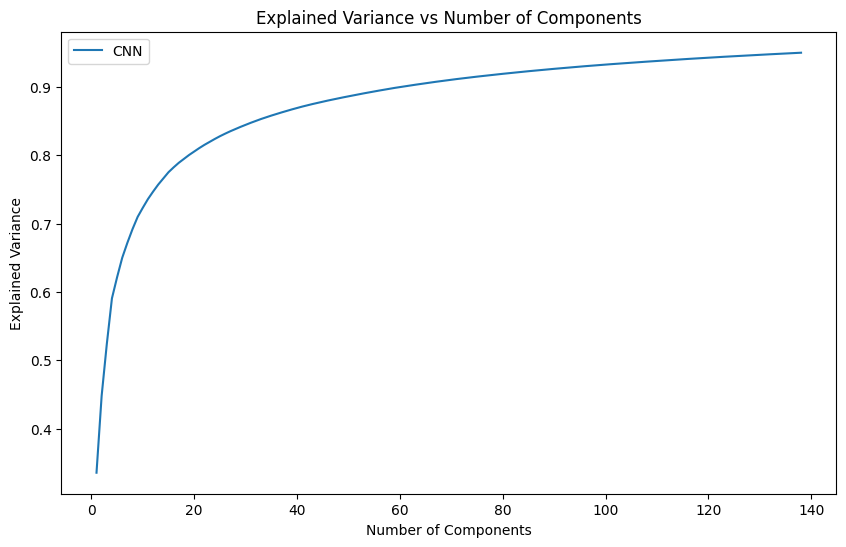

In [ ]:
# CNN
pca = PCA(n_components=.95)
pca.fit(feature_cnn_std)

feature_cnn_reduced = pca.transform(feature_cnn_std)

explained_variance_cnn = pca.explained_variance_ratio_
cumulative_explained_variance_cnn = np.cumsum(explained_variance_cnn)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_explained_variance_cnn) + 1), cumulative_explained_variance_cnn)
plt.legend(['CNN'])
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title('Explained Variance vs Number of Components')
plt.show()

## All feature vectors

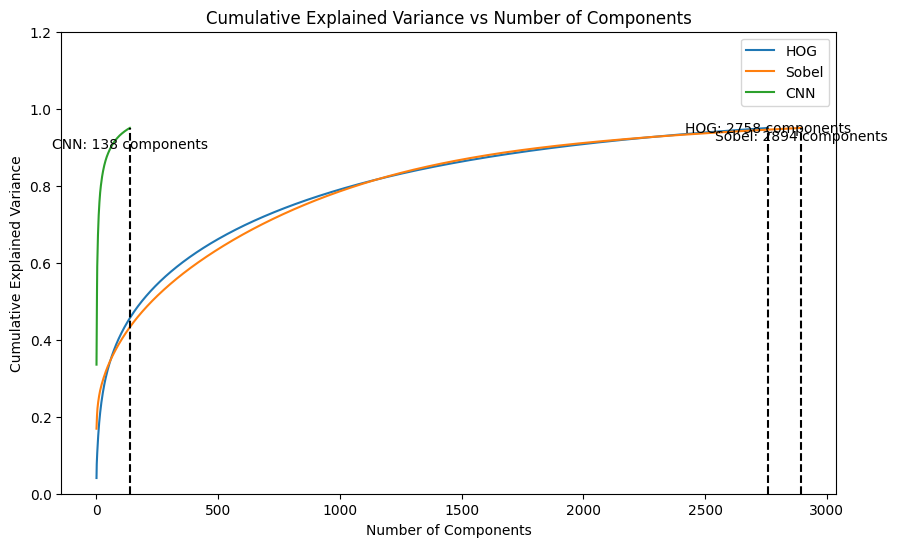

In [ ]:
feature_arrays = [feature_hog_std, feature_sobel_std, feature_cnn_std]
feature_names = ['HOG', 'Sobel', 'CNN']

plt.figure(figsize=(10, 6))

for feature_array, feature_name in zip(feature_arrays, feature_names):
    pca = PCA(n_components=.95)
    pca.fit(feature_array)

    feature_reduced = pca.transform(feature_array)

    explained_variance = pca.explained_variance_ratio_
    cumulative_explained_variance = np.cumsum(explained_variance)

    plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, label=feature_name)


    num_components_95 = np.argmin(np.abs(cumulative_explained_variance - 0.95)) + 1

    # Plot dotted line equivalent to the number of components that explain 95% of the variance
    plt.plot([num_components_95, num_components_95], [0, 0.95], 'k--')
    plt.text(num_components_95, 0.95 - 0.02*(feature_names.index(feature_name)+1), f'{feature_name}: {num_components_95} components', ha='center', va='bottom')

plt.legend()
plt.ylim([0, 1.2])
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs Number of Components')
plt.show()

Total features before PCE:
- HOG: 67392
- Sobel: 110592
- CNN: 2048